# Lab 03 — EKF Simulation

This notebook simulates the **Extended Kalman Filter** running on a commanded trajectory (the same one sent by `send_trajectory.py` / defined in `my_trajectory.py`).

**Structure:**
- **Cell 1** — Shared constants & helpers (run this first)
- **Cell 2** — Prediction-only EKF (no camera correction)
- **Cell 3** — Full EKF (prediction + simulated camera correction)

The trajectory is defined by `TRAJECTORY_SEQUENCE` at the top. Edit it to match what you will send to the robot.

In [5]:
# ============================================================
# CELL 1 — Constants, helpers, trajectory definition
#           Run this cell first before anything else.
# ============================================================
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse

# ------------------------------------------------------------
# TRAJECTORY — edit this to match your send_trajectory.py
# Format: (speed_cmd, steering_cmd, duration_sec)
# steering_cmd: positive = left, negative = right
# ------------------------------------------------------------
TRAJECTORY_SEQUENCE = [
    (100,  0,  1.0),   # Straight
    (100, 10,  2.0),   # Left turn
    ( 80,-10,  2.0),   # Right turn
    (100,  0,  1.0),   # Straight
]

# Simulation timestep (seconds)
DT = 0.05

# ------------------------------------------------------------
# Lab 2 calibrated motion model constants
# ------------------------------------------------------------
K_SE  = 2.882760254750430982e-04   # m / count
K_SS  = 6.338605358524558586e-08   # m^2 / count  (distance variance per count)
A1    = -2.389748299319578351e+01
A2    =  8.136904761904759642e-01
A3    = -4.658503401360606679e-03
C_R   =  -3.526364371043103914e-05  # (rad/s) / (count/s)
SIGMA_W2_CONST = 1.601538811297278713e-03  # (rad/s)^2
DTH_EPS = 1e-8

# ------------------------------------------------------------
# Camera noise variances (from your 10-pose characterization)
# ------------------------------------------------------------
SIGMA_CAM_X2     = 0.01535   # m^2
SIGMA_CAM_Y2     = 0.02195   # m^2
SIGMA_CAM_THETA2 = 7.03e-4   # rad^2
Q = np.diag([SIGMA_CAM_X2, SIGMA_CAM_Y2, SIGMA_CAM_THETA2])

# How many std-devs to draw the ellipse at
ELLIPSE_NSIGMA = 2.0

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
I3 = np.eye(3)

def wrap_to_pi(a):
    return (a + math.pi) % (2 * math.pi) - math.pi

def counts_per_sec_from_speed(v_cmd, v_min=40.0, v_max=100.0):
    v = float(np.clip(v_cmd, v_min, v_max))
    r = A1*v + A2*v**2 + A3*v**3
    return max(0.0, r)

def rotational_velocity_w(v_cmd, steering_cmd):
    """Yaw rate in rad/s."""
    r = counts_per_sec_from_speed(v_cmd)
    return C_R * r * float(steering_cmd)

# ------------------------------------------------------------
# Simulate the commanded trajectory → list of (enc, v_cmd, steer, t)
# ------------------------------------------------------------
def build_command_timeline(traj_seq, dt=DT):
    """Convert TRAJECTORY_SEQUENCE to a flat list of control samples."""
    timeline = []  # each entry: (time, cumul_encoder_counts, v_cmd, steering_cmd)
    t = 0.0
    enc = 0.0   # cumulative encoder counts (forward = increasingly negative)
    for (v_cmd, steer, duration) in traj_seq:
        n_steps = int(math.ceil(duration / dt))
        r = counts_per_sec_from_speed(v_cmd)  # counts / sec
        for _ in range(n_steps):
            enc -= r * dt   # forward motion → counts go negative
            timeline.append((t, enc, v_cmd, steer))
            t += dt
    return timeline

def g_function(state, enc, last_enc, v_cmd, steer, dt):
    """Ackermann mid-heading kinematic step (deterministic mean)."""
    delta_e = enc - last_enc
    e_fwd   = -delta_e
    s       = K_SE * e_fwd
    w       = rotational_velocity_w(v_cmd, steer)
    dth     = w * dt
    x, y, th = state
    th_mid  = th + 0.5 * dth
    x_new   = x  + s * math.cos(th_mid)
    y_new   = y  + s * math.sin(th_mid)
    th_new  = wrap_to_pi(th + dth)
    return np.array([x_new, y_new, th_new]), s, e_fwd

def get_G_x(state, s):
    """Jacobian of g w.r.t. state."""
    th = state[2]
    return np.array([
        [1, 0, -s * math.sin(th)],
        [0, 1,  s * math.cos(th)],
        [0, 0,  1              ]
    ])

def get_G_u(state, v_cmd, dt):
    """Jacobian of g w.r.t. control (3x2)."""
    th = state[2]
    ds_dec  = -K_SE
    r       = counts_per_sec_from_speed(v_cmd)
    dw_dsc  = C_R * r
    return np.array([
        [math.sin(th) * ds_dec,  0.0         ],
        [math.sin(th) * ds_dec,  0.0         ],
        [0.0,                    dw_dsc * dt ]
    ])

def get_R(e_fwd, state, v_cmd, dt):
    """Process noise covariance R_t = G_u * Sigma_u * G_u^T."""
    sigma_s2     = max(0.0, K_SS * abs(e_fwd))
    sigma_theta2 = SIGMA_W2_CONST * dt**2
    Sigma_u = np.diag([sigma_s2, sigma_theta2])
    G_u = get_G_u(state, v_cmd, dt)
    R   = G_u @ Sigma_u @ G_u.T
    return 0.5 * (R + R.T)   # ensure symmetry

def draw_ellipse(ax, mean, cov2x2, n_sigma=ELLIPSE_NSIGMA, **kwargs):
    """Draw a 2D covariance ellipse on ax."""
    eigvals, eigvecs = np.linalg.eigh(cov2x2)
    eigvals = np.maximum(eigvals, 0)   # numerical safety
    angle   = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    w = 2 * n_sigma * math.sqrt(eigvals[0])
    h = 2 * n_sigma * math.sqrt(eigvals[1])
    ell = Ellipse(xy=(mean[0], mean[1]), width=w, height=h,
                  angle=angle, **kwargs)
    ax.add_patch(ell)

print("✅  Cell 1 ready — constants and helpers loaded.")
print(f"Trajectory duration: {sum(d for _,_,d in TRAJECTORY_SEQUENCE):.1f} s  |  steps: {len(build_command_timeline(TRAJECTORY_SEQUENCE))}")

✅  Cell 1 ready — constants and helpers loaded.
Trajectory duration: 6.0 s  |  steps: 120


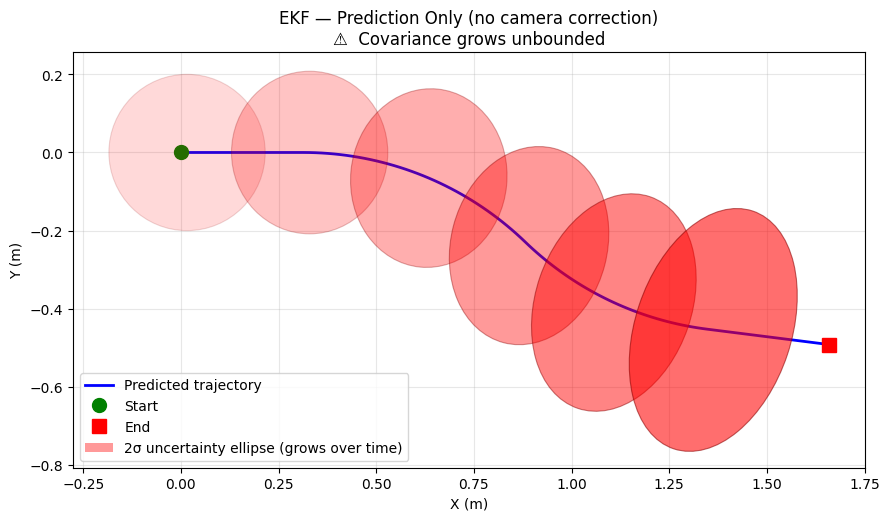


📊 Final uncertainty (prediction only):
   σ_x  = 10.9 cm
   σ_y  = 17.6 cm
   σ_θ  = 5.0 deg


In [6]:
# ============================================================
# CELL 2 — EKF PREDICTION ONLY  (no camera correction)
#
# Shows how uncertainty GROWS over time when no measurements
# are available — the robot drifts and becomes less certain.
# ============================================================

# --- Initial state ---
x0     = np.array([0.0, 0.0, 0.0])   # start at origin, facing right (+x)
Sigma0 = np.diag([0.01, 0.01, (np.deg2rad(5))**2])   # small initial uncertainty

# --- How often to draw an ellipse (every N steps) ---
ELLIPSE_EVERY = 20

# --- Run prediction-only EKF ---
timeline  = build_command_timeline(TRAJECTORY_SEQUENCE)
state     = x0.copy()
Sigma     = Sigma0.copy()
last_enc  = 0.0

traj_x, traj_y = [state[0]], [state[1]]
ellipse_records = []  # (mean_xy, cov2x2)

for step, (t, enc, v_cmd, steer) in enumerate(timeline):
    # --- Prediction ---
    new_state, s, e_fwd = g_function(state, enc, last_enc, v_cmd, steer, DT)
    G_x = get_G_x(state, s)
    R   = get_R(e_fwd, state, v_cmd, DT)
    Sigma = G_x @ Sigma @ G_x.T + R

    state    = new_state
    last_enc = enc
    traj_x.append(state[0])
    traj_y.append(state[1])

    if step % ELLIPSE_EVERY == 0:
        ellipse_records.append((state[:2].copy(), Sigma[:2, :2].copy()))

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(traj_x, traj_y, 'b-', linewidth=2, label='Predicted trajectory')
ax.plot(traj_x[0], traj_y[0], 'go', markersize=10, label='Start')
ax.plot(traj_x[-1], traj_y[-1], 'rs', markersize=10, label='End')

for i, (mean_xy, cov2x2) in enumerate(ellipse_records):
    alpha = 0.15 + 0.5 * (i / len(ellipse_records))  # darker = later
    draw_ellipse(ax, mean_xy, cov2x2,
                 facecolor='red', edgecolor='darkred',
                 alpha=alpha, linewidth=0.8, zorder=3)

# Add a fake patch just for the legend
ellipse_patch = mpatches.Patch(facecolor='red', alpha=0.4, label=f'{ELLIPSE_NSIGMA:.0f}\u03c3 uncertainty ellipse (grows over time)')
ax.legend(handles=[*ax.get_legend_handles_labels()[0], ellipse_patch])

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('EKF — Prediction Only (no camera correction)\n⚠️  Covariance grows unbounded')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final uncertainty
final_std_x  = math.sqrt(Sigma[0, 0])
final_std_y  = math.sqrt(Sigma[1, 1])
final_std_th = math.degrees(math.sqrt(Sigma[2, 2]))
print(f"\n📊 Final uncertainty (prediction only):")
print(f"   σ_x  = {final_std_x*100:.1f} cm")
print(f"   σ_y  = {final_std_y*100:.1f} cm")
print(f"   σ_θ  = {final_std_th:.1f} deg")

/var/folders/k9/3yp284wj22762y3ql1wswlr80000gn/T/ipykernel_56740/2114181904.py:141: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


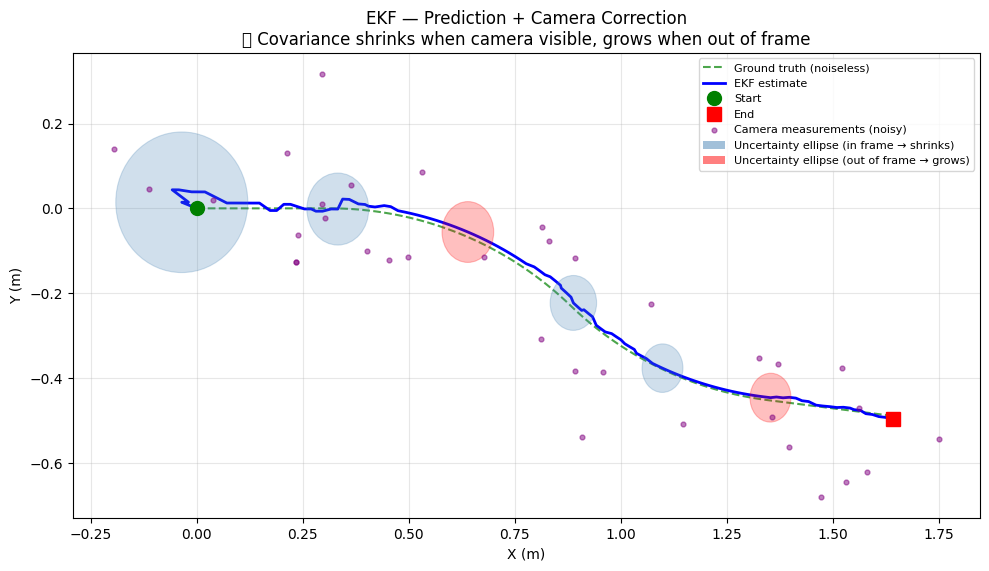


📊 Final uncertainty (full EKF):
   σ_x  = 2.1 cm
   σ_y  = 2.5 cm
   σ_θ  = 0.3 deg
   Final position error vs. ground truth: 1.7 cm


In [7]:
# ============================================================
# CELL 3 — FULL EKF  (prediction + simulated camera correction)
#
# Camera measurements are SIMULATED:
#   - True pose = deterministic Ackermann model (no noise)
#   - Camera measurement = true pose + Gaussian noise (Q)
#   - Camera is "out of frame" in the OUT_OF_FRAME_INTERVAL windows
#     (correction step is skipped → ellipse grows back)
# ============================================================
import random

# --- Configuration ---
x0     = np.array([0.0, 0.0, 0.0])
Sigma0 = np.diag([0.01, 0.01, (np.deg2rad(5))**2])

# Time windows (in seconds) where the robot is OUT OF FRAME
# (set to [] if you want camera always visible)
OUT_OF_FRAME_INTERVALS = [
    (1.5, 2.5),   # e.g., second 1.5 to 2.5
    (4.0, 5.0),
]

ELLIPSE_EVERY = 20
CAMERA_HZ     = 10   # camera fires at 10 Hz (every 0.1 s)
rng           = np.random.default_rng(42)

def is_out_of_frame(t, intervals):
    for (t0, t1) in intervals:
        if t0 <= t <= t1:
            return True
    return False

# --- Run the true trajectory (noiseless) for ground truth ---
timeline     = build_command_timeline(TRAJECTORY_SEQUENCE)
true_state   = x0.copy()
true_last_enc = 0.0
true_traj_x, true_traj_y = [true_state[0]], [true_state[1]]
true_states  = [true_state.copy()]
for (t, enc, v_cmd, steer) in timeline:
    true_state, _, _ = g_function(true_state, enc, true_last_enc, v_cmd, steer, DT)
    true_last_enc = enc
    true_traj_x.append(true_state[0])
    true_traj_y.append(true_state[1])
    true_states.append(true_state.copy())

# --- Run full EKF ---
state    = x0.copy()
Sigma    = Sigma0.copy()
last_enc = 0.0

ekf_traj_x, ekf_traj_y = [state[0]], [state[1]]
cam_meas_x, cam_meas_y = [], []
ellipse_records = []
in_frame_flags  = []

camera_tick   = 0.0
next_cam_time = 0.0

for step, (t, enc, v_cmd, steer) in enumerate(timeline):

    # --- Prediction ---
    pred_state, s, e_fwd = g_function(state, enc, last_enc, v_cmd, steer, DT)
    G_x   = get_G_x(state, s)
    R     = get_R(e_fwd, state, v_cmd, DT)
    Sigma_bar = G_x @ Sigma @ G_x.T + R

    # --- Correction (if camera fires this tick and robot in frame) ---
    if t >= next_cam_time and not is_out_of_frame(t, OUT_OF_FRAME_INTERVALS):
        next_cam_time = t + 1.0 / CAMERA_HZ
        true_pose = true_states[step + 1]   # noiseless ground truth

        # Simulated noisy camera measurement
        noise = rng.multivariate_normal([0, 0, 0], Q)
        z_t   = true_pose + noise
        z_t[2] = wrap_to_pi(z_t[2])
        cam_meas_x.append(z_t[0])
        cam_meas_y.append(z_t[1])

        # Kalman gain (H = I3)
        S = Sigma_bar + Q
        K = Sigma_bar @ np.linalg.inv(S)

        # Innovation
        innov    = z_t - pred_state
        innov[2] = wrap_to_pi(innov[2])

        # Update
        state = pred_state + K @ innov
        state[2] = wrap_to_pi(state[2])
        Sigma = (np.eye(3) - K) @ Sigma_bar
        in_frame_flags.append(True)
    else:
        if t >= next_cam_time:   # out of frame — advance timer
            next_cam_time = t + 1.0 / CAMERA_HZ
        state = pred_state
        Sigma = Sigma_bar
        in_frame_flags.append(False)

    last_enc = enc
    ekf_traj_x.append(state[0])
    ekf_traj_y.append(state[1])

    if step % ELLIPSE_EVERY == 0:
        in_frame = not is_out_of_frame(t, OUT_OF_FRAME_INTERVALS)
        ellipse_records.append((state[:2].copy(), Sigma[:2, :2].copy(), in_frame))

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 7))

# Ground truth
ax.plot(true_traj_x, true_traj_y, 'g--', linewidth=1.5, alpha=0.7, label='Ground truth (noiseless)')

# EKF estimate
ax.plot(ekf_traj_x, ekf_traj_y, 'b-', linewidth=2, label='EKF estimate')
ax.plot(ekf_traj_x[0], ekf_traj_y[0], 'go', markersize=10, zorder=5, label='Start')
ax.plot(ekf_traj_x[-1], ekf_traj_y[-1], 'rs', markersize=10, zorder=5, label='End')

# Camera measurements
if cam_meas_x:
    ax.scatter(cam_meas_x, cam_meas_y, c='purple', s=12, alpha=0.5, zorder=4, label='Camera measurements (noisy)')

# Covariance ellipses
for i, (mean_xy, cov2x2, in_frame) in enumerate(ellipse_records):
    color = 'steelblue' if in_frame else 'red'
    alpha = 0.25
    draw_ellipse(ax, mean_xy, cov2x2,
                 facecolor=color, edgecolor=color,
                 alpha=alpha, linewidth=0.8, zorder=3)

# Shade out-of-frame windows on x-axis guide
blue_patch  = mpatches.Patch(facecolor='steelblue', alpha=0.5, label='Uncertainty ellipse (in frame → shrinks)')
red_patch   = mpatches.Patch(facecolor='red',       alpha=0.5, label='Uncertainty ellipse (out of frame → grows)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles + [blue_patch, red_patch], fontsize=8)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('EKF — Prediction + Camera Correction\n✅ Covariance shrinks when camera visible, grows when out of frame')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final uncertainty
final_std_x  = math.sqrt(Sigma[0, 0])
final_std_y  = math.sqrt(Sigma[1, 1])
final_std_th = math.degrees(math.sqrt(Sigma[2, 2]))
print(f"\n📊 Final uncertainty (full EKF):")
print(f"   σ_x  = {final_std_x*100:.1f} cm")
print(f"   σ_y  = {final_std_y*100:.1f} cm")
print(f"   σ_θ  = {final_std_th:.1f} deg")

# Position error at end
pos_err = math.sqrt((ekf_traj_x[-1] - true_traj_x[-1])**2 +
                    (ekf_traj_y[-1] - true_traj_y[-1])**2)
print(f"   Final position error vs. ground truth: {pos_err*100:.1f} cm")

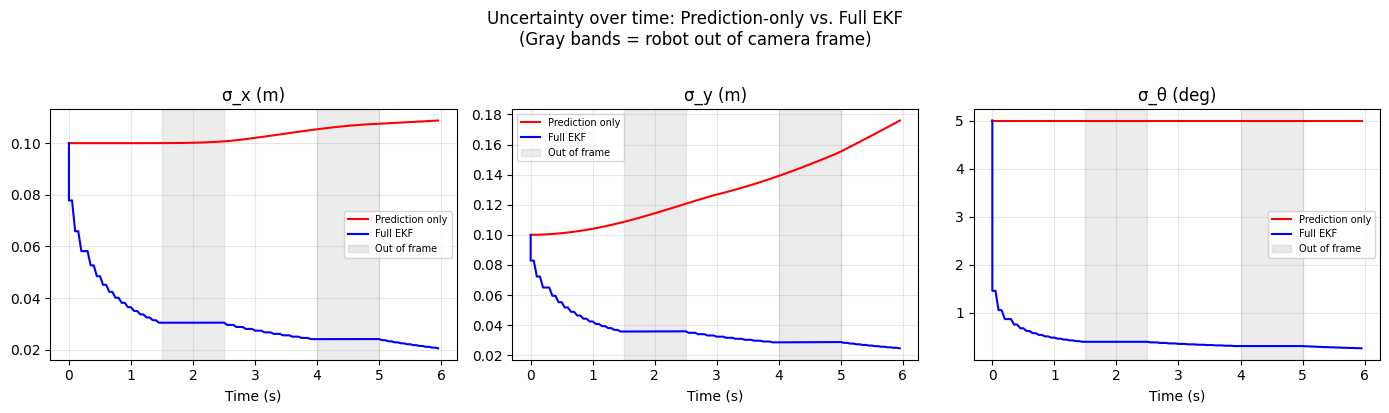

In [8]:
# ============================================================
# CELL 4 (bonus) — Covariance magnitude over time
#
# Plots σ_x, σ_y, σ_θ over the trajectory duration for both
# prediction-only and full EKF — side by side.
# ============================================================

def run_ekf(use_correction, out_of_frame_intervals=None):
    """Re-run EKF and collect std history. Returns (times, stds_x, stds_y, stds_th)."""
    if out_of_frame_intervals is None:
        out_of_frame_intervals = []
    state    = x0.copy()
    Sigma    = Sigma0.copy()
    last_enc = 0.0
    times, stds_x, stds_y, stds_th = [0.0], [math.sqrt(Sigma[0,0])], [math.sqrt(Sigma[1,1])], [math.degrees(math.sqrt(Sigma[2,2]))]
    next_cam_time = 0.0
    for step, (t, enc, v_cmd, steer) in enumerate(timeline):
        pred_state, s, e_fwd = g_function(state, enc, last_enc, v_cmd, steer, DT)
        G_x    = get_G_x(state, s)
        R      = get_R(e_fwd, state, v_cmd, DT)
        Sigma_bar = G_x @ Sigma @ G_x.T + R
        if use_correction and t >= next_cam_time and not is_out_of_frame(t, out_of_frame_intervals):
            next_cam_time = t + 1.0 / CAMERA_HZ
            true_pose = true_states[step + 1]
            noise = rng.multivariate_normal([0, 0, 0], Q)
            z_t   = true_pose + noise
            z_t[2] = wrap_to_pi(z_t[2])
            S = Sigma_bar + Q
            K = Sigma_bar @ np.linalg.inv(S)
            innov    = z_t - pred_state
            innov[2] = wrap_to_pi(innov[2])
            state = pred_state + K @ innov
            state[2] = wrap_to_pi(state[2])
            Sigma = (np.eye(3) - K) @ Sigma_bar
        else:
            if use_correction and t >= next_cam_time:
                next_cam_time = t + 1.0 / CAMERA_HZ
            state = pred_state
            Sigma = Sigma_bar
        last_enc = enc
        times.append(t)
        stds_x.append(math.sqrt(max(0, Sigma[0,0])))
        stds_y.append(math.sqrt(max(0, Sigma[1,1])))
        stds_th.append(math.degrees(math.sqrt(max(0, Sigma[2,2]))))
    return times, stds_x, stds_y, stds_th

t_pred, sx_pred, sy_pred, sth_pred = run_ekf(use_correction=False)
t_full, sx_full, sy_full, sth_full = run_ekf(use_correction=True, out_of_frame_intervals=OUT_OF_FRAME_INTERVALS)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
titles = ['σ_x (m)', 'σ_y (m)', 'σ_θ (deg)']
for i, (ax_p, sp, sf, title) in enumerate(zip(axes,
        [sx_pred, sy_pred, sth_pred],
        [sx_full, sy_full, sth_full],
        titles)):
    ax_p.plot(t_pred, sp, 'r-', label='Prediction only')
    ax_p.plot(t_full, sf, 'b-', label='Full EKF')
    for (t0, t1) in OUT_OF_FRAME_INTERVALS:
        ax_p.axvspan(t0, t1, alpha=0.15, color='gray', label='Out of frame' if t0 == OUT_OF_FRAME_INTERVALS[0][0] else '')
    ax_p.set_title(title)
    ax_p.set_xlabel('Time (s)')
    ax_p.legend(fontsize=7)
    ax_p.grid(True, alpha=0.3)

fig.suptitle('Uncertainty over time: Prediction-only vs. Full EKF\n(Gray bands = robot out of camera frame)', y=1.02)
plt.tight_layout()
plt.show()